# Policy Gradient

In reinforcement learning, the goal is to find a policy that maximizes the expected cumulative reward over time. Policy Gradient (PG) methods are a class of algorithms for finding such policies in which the policy is represented by a parameterized function, such as a neural network. The key idea behind PG methods is to adjust the parameters of the policy in the direction that increases the expected reward. This is done by computing the gradient of the expected reward with respect to the policy parameters and updating the parameters in the direction of the gradient.

Unfortunately, calculating exact policy gradient requires iterating over the entire state-action space, which is unfeasible in most problems. As such, we estimate the gradient with a sample of recent transitions, which were sampled according to the policy. In its simplest form, PG is equal to:

$$
\nabla_{\theta} J = \underset{s \sim p^{\pi}_{*}}{\mathbb{E}} ~ \underset{a \sim \pi}{\mathbb{E}} ~ Q^{\pi} (s, a) ~ \nabla_{\theta} \log \pi_{\theta} (a | s)
$$

Where $p^{\pi}_{*}$ is the discounted stationary distribution, $\pi_{\theta}(a|s)$ is the policy and $Q^{\pi} (s, a)$ denotes the Q-value under policy. Some of the popular policy gradient algorithm are Actor-Critic and PPO. These algorithm use different techniques to estimate the gradient and update the policy.

Tasks:

1. Run the **PolicyGradient** agent. Plot mean+std of rewards during the training.
2. Implement the *update* method for **BaselinedPolicyGradient** class. Run the agent, plot mean+std of rewards during the training.
3. Implement the *update* method for **ActorCritic** class. Run the agent, plot mean+std of rewards during the training.

In [1]:
!pip3 install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 8.4 MB/s eta 0:00:00


We import required modules and fix hyperparamters:

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import time
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt

In [3]:
# do not change!
class parse_args:
    def __init__(self):
        self.gym_id = "CartPole-v1"
        self.batch_size = 32
        self.hidden_dim = 32
        self.learning_rate = 5e-3
        self.discount = 0.99
        self.timesteps = 10000
        self.repeats = 10
        self.eval_steps = 500
        self.cuda = True
        env = gym.make(self.gym_id)
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.device = torch.device("cpu")

args = parse_args()

We define a policy network (**ActorNetwork**) and a value network (**CriticNetwork**). Value network has multiple uses, but we will initially use it to bootstrap Q-values of unfinished episodes.

Why do we need such bootstrap? Our environment can run up to 200 steps before termination. Given batch size of 32, we will never be able to get entire episode in one batch. As PG requires Q-values of all state-actions in the batch, we have to find a way of calculating the Q-values past our batch.

In [4]:
class ActorNetwork(nn.Module):
    def __init__(self, args):
        super(ActorNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(args.state_size, args.hidden_dim), nn.ReLU(),
            nn.Linear(args.hidden_dim, args.action_size))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return nn.Softmax(1)(self.layers(x))

class CriticNetwork(nn.Module):
    def __init__(self, args: parse_args):
        super(CriticNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(args.state_size, args.hidden_dim), nn.ReLU(),
            nn.Linear(args.hidden_dim, 1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

Below, we implement the PG agent. There are two important methods here:

1. *get_qvalues* - calculate Q-values for the batch. If final state is not terminating, use value network to estimate value of past final state.
2. *update* - update actor and citic networks.

In [5]:
class PolicyGradient(nn.Module):
    def __init__(self, args):
        super(PolicyGradient, self).__init__()
        self.args = args
        self.init_networks()

    def reset(self):
        self.logprobs = torch.zeros(self.args.batch_size, device=self.args.device)
        self.values = torch.zeros(self.args.batch_size, device=self.args.device)
        self.rewards = torch.zeros(self.args.batch_size, device=self.args.device)
        self.terminals = torch.zeros(self.args.batch_size, device=self.args.device)
        self.idx = 0

    def init_networks(self):
        self.actor = ActorNetwork(self.args).to(self.args.device)
        self.critic = CriticNetwork(self.args).to(self.args.device)
        self.optimizer = optim.Adam(list(self.actor.parameters()) + list(self.critic.parameters()), lr=self.args.learning_rate)
        self.reset()

    def add(self, logprob: torch.Tensor, value: torch.Tensor, reward, terminal):
        self.logprobs[self.idx] = logprob
        self.values[self.idx] = value
        self.rewards[self.idx] = reward
        self.terminals[self.idx] = terminal
        self.idx += 1

    def get_action_and_value(self, x: torch.Tensor) -> Tuple[int, torch.Tensor, torch.Tensor]:
        probs = self.actor(x)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action), self.critic(x)

    def get_qvalues(self, final_state: torch.Tensor):
        with torch.no_grad():
            final_state_value = self.critic(final_state)
        q_values = torch.zeros_like(self.rewards).to(self.args.device)
        for timestep in reversed(range(self.args.batch_size)):
            next_value = final_state_value if timestep == (self.args.batch_size - 1) else q_values[timestep + 1]
            q_values[timestep] = self.rewards[timestep] + self.args.discount * (1 - self.terminals[timestep]) * next_value
        return q_values

    def update(self, q_values: torch.Tensor):
        policy_loss = -(self.logprobs * q_values.detach()).mean()
        value_loss = (self.values - q_values.detach()).pow(2).mean()
        loss = (policy_loss + 0.5*value_loss)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.reset()

    def evaluate(self, samples: int):
        with torch.no_grad():
            env_test = gym.make(self.args.gym_id)
            eval_reward = 0
            for i in range(samples):
                state, _ = env_test.reset()
                episode_reward = 0
                while True:
                    action, _, _ = self.get_action_and_value(torch.tensor(state, device=args.device).unsqueeze(0))
                    next_state, reward, terminal, truncated, _ = env_test.step(action)
                    done = terminal or truncated
                    episode_reward += reward
                    state = next_state
                    if done:
                        eval_reward += episode_reward/samples
                        break
        return eval_reward

Finally, a function to train the agent:

In [6]:
def train(args, agent: PolicyGradient):
    rewards = np.zeros((args.timesteps//args.eval_steps, args.repeats))
    for seed in range(args.repeats):
        agent.init_networks()
        env = gym.make(args.gym_id)
        state, _ = env.reset(seed=seed)
        start_time = time.time()
        for step in range(args.timesteps):
            action, logprob, value = agent.get_action_and_value(torch.tensor(state, device=args.device).unsqueeze(0))
            next_state, reward, terminal, truncated, _ = env.step(action)
            done = terminal or truncated
            agent.add(logprob, value, reward, done)
            state = next_state
            if agent.idx == args.batch_size:
                q_values = agent.get_qvalues(torch.tensor(state, device=args.device).unsqueeze(0))
                agent.update(q_values)
            if (step+1) % args.eval_steps == 0:
                eval_rewards = agent.evaluate(5)
                rewards[step//args.eval_steps, seed] = eval_rewards
                if (step+1) % (10 * args.eval_steps) == 0:
                    print(f"step={step+1}, eval_return={np.round(eval_rewards, 1)}, samples_per_sec={int(step / (time.time() - start_time))}")
            if done:
                state, _ = env.reset(seed=seed)
    return rewards

In [11]:
agent = PolicyGradient(args)
rewards = train(args, agent)

step=5000, eval_return=33.2, samples_per_sec=641
step=10000, eval_return=133.0, samples_per_sec=538
step=5000, eval_return=150.8, samples_per_sec=588
step=10000, eval_return=313.6, samples_per_sec=482
step=5000, eval_return=96.4, samples_per_sec=588
step=10000, eval_return=414.0, samples_per_sec=474
step=5000, eval_return=149.4, samples_per_sec=600
step=10000, eval_return=346.8, samples_per_sec=471
step=5000, eval_return=37.6, samples_per_sec=619
step=10000, eval_return=185.4, samples_per_sec=558
step=5000, eval_return=42.4, samples_per_sec=637
step=10000, eval_return=235.6, samples_per_sec=554
step=5000, eval_return=37.8, samples_per_sec=613
step=10000, eval_return=73.0, samples_per_sec=595
step=5000, eval_return=79.4, samples_per_sec=582
step=10000, eval_return=386.6, samples_per_sec=549
step=5000, eval_return=68.6, samples_per_sec=651
step=10000, eval_return=210.4, samples_per_sec=561
step=5000, eval_return=65.4, samples_per_sec=591
step=10000, eval_return=93.4, samples_per_sec=504


[ 20.58  24.58  32.64  43.    39.08  45.94  46.28  67.5   55.46  76.1
 106.36  88.9   78.02 109.86 143.6  130.82 123.6  138.58 124.64 239.18]
[  5.55586177   7.87880702   9.44618441  13.1249381   10.02245479
  11.49819116  14.7510542   26.63775516  21.83191242  41.79944976
  33.4456933   28.67406494  35.62431192  58.88001698  98.72564003
  60.12935722  60.31470799  59.61318311  60.15093017 115.45140796]


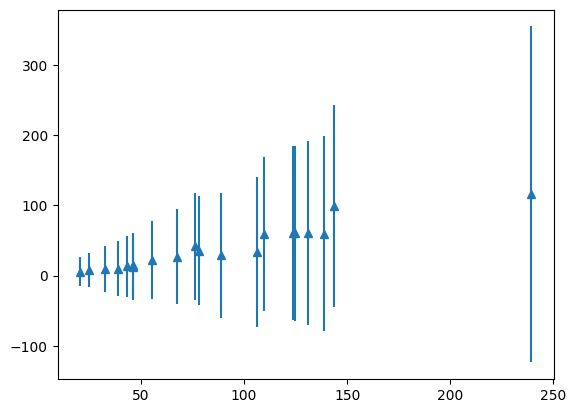

In [23]:
# GRAPH RESULTS HERE (MEAN + STD)
reward = np.array(rewards)
mean = reward.mean(1)
std = reward.std(1)
print(mean)
print(std)

plt.errorbar(mean, std, mean, linestyle='None', marker='^')
plt.show()

PG estimate has big variance - the estimate will vary a lot depending on the states and actions sampled. This variance is known to impact the sample efficiency and final performance of the agent. Although there are many strategies fo PG variance reduction, there is one trick that became indispensable in modern implementations of PG - baseline trick. But before we get to this, lets have one more look at the standard PG estimate:

$$
\nabla_{\theta} J = \underset{s \sim p^{\pi}_{*}}{\mathbb{E}} ~ \underset{a \sim \pi}{\mathbb{E}} ~ Q^{\pi} (s, a) ~ \nabla_{\theta} \log \pi_{\theta} (a | s)
$$

As mentioned in the lecture, PG nature is quite simple - increase the probability of good actions and decrease the probability of bad ones. 'Good' and 'bad' refer to Q-values associated with given actions. But what if all Q-values are positive? The gradient update will try to increase the probabilities of all sampled actions, with the increase being proportional to the Q-value (as stems from the equation above). As such, given positive Q-values, the probabilities of bad actions are also increased - just by a smaller amount that probabilities of actions with bigger Q-values.

Baseline variance reduction tackles exactly that. The idea is to subtract a "baseline" from the Q-values, which does not affect the optimal policy, but reduces the variance of the gradients. It is proven that as long as the baseline does not depend on the action, its value will not bias the PG (however, inadequate baseline can actually increase the variance :)). So, what is a good baseline?

The simplest version subtracts batch average of Q-values from each Q-value:

$$
\nabla_{\theta} J = \sum_{i=1}^{B} \frac{1}{B} \bigl( Q^{\pi} (s_i, a_i) - \frac{\sum Q^{\pi} (s_i, a_i)}{B} \bigr) \nabla_{\theta} \log \pi_{\theta} (a_i | s_i)
$$

Where B is the batch size and $\frac{\sum Q^{\pi} (s_i, a_i)}{B}$ is the average Q-value in the batch.

In [26]:
class BaselinedPolicyGradient(PolicyGradient):
    def __init__(self, args):
        super(BaselinedPolicyGradient, self).__init__(args)

    def update(self, q_values: torch.Tensor):
        policy_loss = -((q_values - q_values.mean()).detach() * self.logprobs).mean()
        value_loss = (self.values - q_values.deatch()).pow(2).mean()
        loss = (policy_loss + 0.5*value_loss)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.reset()

In [27]:
agent = BaselinedPolicyGradient(args)
rewards2 = train(args, agent)

step=5000, eval_return=63.6, samples_per_sec=595
step=10000, eval_return=305.6, samples_per_sec=471
step=5000, eval_return=48.6, samples_per_sec=700
step=10000, eval_return=68.8, samples_per_sec=572
step=5000, eval_return=82.0, samples_per_sec=580
step=10000, eval_return=136.4, samples_per_sec=448
step=5000, eval_return=54.6, samples_per_sec=594
step=10000, eval_return=456.2, samples_per_sec=466
step=5000, eval_return=171.2, samples_per_sec=530
step=10000, eval_return=146.8, samples_per_sec=458
step=5000, eval_return=63.8, samples_per_sec=587
step=10000, eval_return=192.4, samples_per_sec=442
step=5000, eval_return=46.2, samples_per_sec=599
step=10000, eval_return=113.0, samples_per_sec=544
step=5000, eval_return=109.6, samples_per_sec=541
step=10000, eval_return=266.4, samples_per_sec=420
step=5000, eval_return=96.0, samples_per_sec=570
step=10000, eval_return=254.6, samples_per_sec=463
step=5000, eval_return=68.2, samples_per_sec=587
step=10000, eval_return=422.6, samples_per_sec=424

[ 21.44  28.18  33.    38.52  42.94  44.34  55.26  58.2   79.42  80.38
 121.62 129.8  148.44 143.22 158.78 180.8  174.34 216.56 235.12 236.28]
[  7.26074376   9.54461104  14.92514657  15.68418312  14.28231074
  13.69088748  14.76727463  24.00216657  25.99483795  35.91149677
  60.25986724  45.06688363  81.84232646  62.48861976  89.4358966
  66.17927168  66.8593778   93.19861802 115.79188918 123.40328035]


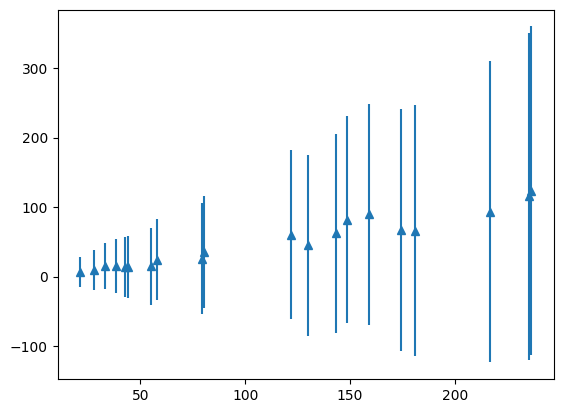

In [ ]:
reward = np.array(rewards2)
mean = reward.mean(1)
std = reward.std(1)
print(mean)
print(std)

plt.errorbar(mean, std, mean, linestyle='None', marker='^')
plt.show()

The most popular approach is to use state value as the baseline. Then, the gradient is well centered - probability of actions with Q-values smaller than state value will be decreased and probability of actions with Q-values bigger than state value will be increased. Obviously, we do not know the values associated with each state. To this end, we leverage a **CriticNetwork**. This network outputs value of a state and is trained using MSE using Q-values as targets. Traditionally, PG algorithm that uses value network for baseline variance reduction is called Actor-Critic. Actor Critic update is calculated with:

$$
\nabla_{\theta} J = \sum_{i=1}^{B} \frac{1}{B} \bigl( Q^{\pi} (s_i, a_i) - V_{\phi}(s) \bigr) \nabla_{\theta} \log \pi_{\theta} (a_i | s_i)
$$

Where $\bigl( Q^{\pi} (s_i, a_i) - V_{\phi}(s) \bigr)$ is referred to as **advantage**.

In [31]:
class ActorCritic(PolicyGradient):
    def __init__(self, args):
        super(ActorCritic, self).__init__(args)

    def update(self, q_values: torch.Tensor):
        ## TODO {
        policy_loss = -((q_values - self.values).detach() * self.logprobs).mean() # policy not values
        value_loss = (self.values - q_values.detach()).pow(2).mean()
        loss = (policy_loss + 0.5*value_loss)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.reset()

        ##}

In [ ]:
agent = ActorCritic(args)
rewards3 = train(args, agent)

step=5000, eval_return=130.2, samples_per_sec=575
step=10000, eval_return=182.0, samples_per_sec=454
step=5000, eval_return=82.0, samples_per_sec=544
step=10000, eval_return=229.8, samples_per_sec=425
step=5000, eval_return=102.2, samples_per_sec=579
step=10000, eval_return=327.2, samples_per_sec=450
step=5000, eval_return=190.0, samples_per_sec=527
step=10000, eval_return=215.0, samples_per_sec=382
step=5000, eval_return=186.6, samples_per_sec=430
step=10000, eval_return=327.8, samples_per_sec=393
step=5000, eval_return=98.0, samples_per_sec=575
step=10000, eval_return=434.0, samples_per_sec=462
step=5000, eval_return=79.4, samples_per_sec=631
step=10000, eval_return=92.8, samples_per_sec=488
step=5000, eval_return=82.0, samples_per_sec=574
step=10000, eval_return=275.2, samples_per_sec=503
step=5000, eval_return=64.8, samples_per_sec=634
step=10000, eval_return=232.6, samples_per_sec=519
step=5000, eval_return=146.4, samples_per_sec=575
step=10000, eval_return=323.2, samples_per_sec=

In [ ]:
reward = np.array(rewards3)
mean = reward.mean(1)
std = reward.std(1)
print(mean)
print(std)

plt.errorbar(mean, std, mean, linestyle='None', marker='^')
plt.show()

In [ ]:
# GRAPH ALL RESULTS HERE (MEAN + STD)
